## Drive Connect

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Imports

In [2]:
import os
### Need to set following env variable in order to display plots
### Reqd when using matplotlib along with pytorch?
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as mplt
# from scipy.spatial import distance as dist

### Instance Segmentation Data Prep

Person Instance Finding
1. Batsmen (Striker) --> Pitch centre - Upper half
2. Batsmen (Non-Striker) --> Pitch left/right - lower half
3. Bowler --> Pitch left/right - lower half
4. Wicket Keeper --> Pitch left/right - upper half - Near to batsmen
5. Umpire --> Pitch centre - lower half

##### Pseudocode:
1. Read Image
2. Pitch detection
3. Split Image and Object Bbox - Upper and Lower
4. Sort it by x-coordinate
5. Apply logic to find person instances

### Defined Functions

In [3]:
def plt_img(y, cmap=''):
    if cmap:
        mplt.figure(figsize=(14, 10)); mplt.imshow(y, cmap=cmap); mplt.show()
    else:
        mplt.figure(figsize=(14, 10)); mplt.imshow(y); mplt.show()


def getCroppedImage(frame, scr_thresh=0.85, width_thresh=1/4):
    #removing scorecard
    roi = frame
    # roi = roi[:int(roi.shape[0] * 0.85),:]
    roi = roi[:int(roi.shape[0] * scr_thresh),:]
    # cropping center of an image
    # thresh=1/3
    thresh=width_thresh
    end = roi.shape[1] - int(roi.shape[1]*thresh)
    start = int(roi.shape[1]*thresh)
    roi = roi[:,start:end]
    return roi

### Folder Definition

In [18]:
!ls /content/gdrive/MyDrive/Open_Innov/Cricket_Analytics/Cricket\ Analytics/Prabakar/obj_detection/instance_seg

cric_test_train.csv	 cric_test_val_results	      odi_train_results
cric_test_train_results  ins_annt_cric_test_train_v2  odi_val.csv
cric_test_val.csv	 odi_train.csv		      odi_val_results


In [19]:
# obj_det_fld = r'D:\Tiger\Open_Innovation\cv\phase_2\obj_detection'
# ph_2_base_fld = r'D:\Tiger\Open_Innovation\cv\phase_2'
obj_det_fld = '/content/gdrive/MyDrive/Open_Innov/Cricket_Analytics/Cricket Analytics/Prabakar/obj_detection'
ph_2_base_fld = r'D:\Tiger\Open_Innovation\cv\phase_2'

# base_fld = os.path.join(ph_2_base_fld, 'instance_seg/prathyusha_annt')
base_fld = os.path.join(obj_det_fld, 'instance_seg')
fld0 = os.path.join(obj_det_fld, 'csrt_data_v2')

In [20]:
mtype = 'odi_train'
print(os.path.join(base_fld, f'{mtype}.csv'))
sh1 = pd.read_csv(os.path.join(base_fld, f'{mtype}.csv'))
if 'Unnamed: 0' in sh1.columns: sh1.drop('Unnamed: 0', axis=1, inplace=True)
sh1.rename(columns={'confidence': 'conf'}, inplace=True)
print(sh1.columns)
sh1.head()

/content/gdrive/MyDrive/Open_Innov/Cricket_Analytics/Cricket Analytics/Prabakar/obj_detection/instance_seg/odi_train.csv
Index(['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class', 'name', 'Image',
       'Bounding Box'],
      dtype='object')


,xmin,ymin,xmax,ymax,conf,class,name,Image,Bounding Box
0,202.526108,89.616158,275.532104,240.625183,0.927187,0,person_1,ICC_WC_2019_v1_151_153_sh_19__28,"[202.52610778808594, 89.61615753173828, 275.53..."
1,404.608398,352.404633,499.001282,601.276855,0.915133,0,person_2,ICC_WC_2019_v1_151_153_sh_19__28,"[404.6083984375, 352.4046325683594, 499.001281..."
2,202.113235,464.716003,299.094147,610.932678,0.895267,0,person_3,ICC_WC_2019_v1_151_153_sh_19__28,"[202.1132354736328, 464.71600341796875, 299.09..."
3,137.075012,402.066528,239.056458,599.514893,0.817809,0,person_4,ICC_WC_2019_v1_151_153_sh_19__28,"[137.07501220703125, 402.0665283203125, 239.05..."
4,405.171906,480.994019,425.627960,603.979736,0.571027,34,baseball bat_1,ICC_WC_2019_v1_151_153_sh_19__28,"[405.1719055175781, 480.9940185546875, 425.627..."


In [21]:
sh1['cls_nm'] = sh1['name'].apply(lambda x: x.split('_')[0])
sh1['bbox'] = list(zip(sh1['xmin'], sh1['ymin'], sh1['xmax'], sh1['ymax']))
sh1['ctd'] = sh1['bbox'].apply(lambda x: [int((x[0]+x[2])/2), int((x[1]+x[3])/2)])

df_pr = sh1[sh1['cls_nm']=='person'].reset_index(drop=True)
# df_pr['ins_nm'] = df_pr['bbox'].apply(seg_ins)

### Folder Creation

In [ ]:
ires_fld = os.path.join(base_fld, f'ins_annt_{mtype}_v3')
if not os.path.exists(ires_fld):
    print(f'Creating path - {ires_fld}')
    os.mkdir(ires_fld)

Creating path - D:\Tiger\Open_Innovation\cv\phase_2\isntance_seg\prathyusha_annt\ins_annt_odi_train_v3


### Reading Image

(612, 640, 3)


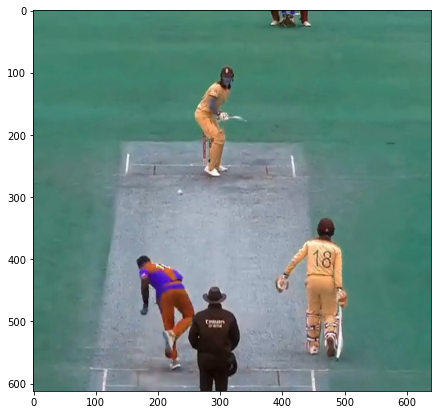

In [ ]:
im_list = df_pr['Image'].unique()
fnm = im_list[2]
mtp0 = 'odi' if 'odi' in mtype else 'cric_test'
# print(os.path.join(fld0, mtp0, f'{fnm}.jpg'))
im0 = cv2.imread(os.path.join(fld0, mtp0, f'{fnm}.jpg'))
print(im0.shape)
plt_img(im0)

### Object Detection Essentials

In [22]:
import sys
# yolo_base = r'D:\Tiger\Open_Innovation\cv\pychm\yolov5'
yolo_base = '/content/gdrive/MyDrive/Open_Innov/Cricket_Analytics/src/prabakar_yolov5_models'
sys.path.append(yolo_base)
from pathlib import Path
import re
# np.random.seed(42)
# COLORS = np.random.randint(0, 255, size=(10, 3), dtype="uint8")
from operator import itemgetter # sort list of lists
import torch
import torch.backends.cudnn as cudnn
# FILE = Path(__file__).resolve()
# FILE = r''
# ROOT = FILE.parents[0]  # YOLOv5 root directory
ROOT = yolo_base
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative
# ROOT = Path(os.path.relpath(ROOT, '/'))  # relative

from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow,
                           check_requirements, colorstr, cv2, increment_path,
                           non_max_suppression, print_args, scale_coords,
                           strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox
import matplotlib.pyplot as plt
%matplotlib inline

##### Defined Functions

In [84]:
def getCroppedImage(frame, scr_thresh=0.85, width_thresh=1/4):
    #removing scorecard
    roi = frame
    # roi = roi[:int(roi.shape[0] * 0.85),:]
    roi = roi[:int(roi.shape[0] * scr_thresh),:]
    # cropping center of an image
    # thresh=1/3
    thresh=width_thresh
    end = roi.shape[1] - int(roi.shape[1]*thresh)
    start = int(roi.shape[1]*thresh)
    roi = roi[:,start:end]
    return roi


def loadYoloModel(
        weights = os.path.join(yolo_base, 'cric_ball_detection2/freeze_layers/weights/best.pt'), # model.pt path(s)
        device='',  # cuda device, i.e. 0 or 0,1,2,3 or cpu
        ):
    if not device:
        device = select_device(device)
    print('device - ', device)
    print('weights - ', weights)
    model = DetectMultiBackend(weights, device=device)
    return model


def preprocess_img_yolo(frame, model, imgsz=(640, 640), stride=32, auto=True, device=''):
    if not device:
        device = select_device(device)
    # print('device - ', device)
    im_pre = frame.copy()
    im = letterbox(im_pre, imgsz, stride=stride, auto=pt)[0]
    # Convert
    im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    im = np.ascontiguousarray(im)
    im = torch.from_numpy(im).to(device)
    im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
    im /= 255  # 0 - 255 to 0.0 - 1.0
    if len(im.shape) == 3:
        im = im[None]  # expand for batch dim
    return im


def getBallDetectYolo(
        scr_frm, model, im0,
        conf_thres=0.25,  # confidence threshold
        iou_thres=0.45,  # NMS IOU threshold
        classes=None,  # filter by class: --class 0, or --class 0 2 3
        agnostic_nms=False,  # class-agnostic NMS
        max_det=1000,  # maximum detections per image
        top_obj_thresh = 0.9,
        ret_top_obj=True
        ):
    # Inference
    # =======> Prediction
    pred = model(scr_frm)
    
    # NMS
    # =======> Non-max suppression
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
    final_list = []
    for i, det in enumerate(pred):  # per image
        # break
        #if torch.any(det):
        # gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        # imc = im0.copy() if save_crop else im0  # for save_crop
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(scr_frm.shape[2:], det[:, :4], im0.shape).round()
            pred_list = []
            # Write results
            for *xyxy, conf, cls in reversed(det):
                # break
                # Top x, Top y, width, height    
                xywh0 = (xyxy2xywh(torch.tensor(xyxy).view(1, 4))).view(-1).tolist()  # normalized xywh
                xywh0[0] = xywh0[0] - xywh0[2]/2
                xywh0[1] = xywh0[1] - xywh0[3]/2
                pred_list.append(list([int(cls.item()), xywh0, conf.item()]))
            pred_list = sorted(pred_list, key=itemgetter(-1), reverse=True)
            if ret_top_obj:
                init_scr = pred_list[0][2]
                if init_scr >= top_obj_thresh:
                    init_bbox = pred_list[0][1]
                    init_bbox = [int(x) for x in init_bbox]
                    final_list.append(pred_list[0])
                # else:
                #     return False
            else:
                final_list.extend(pred_list)
    return final_list


def clean_bbox(x):
    x = re.sub(r'[()\[\]]', '', x)
    x = [int(float(x.strip())) for x in x.split(',')]
    return x

#### Ball Detection

##### Folder paths

In [24]:
yolo_base = r'D:\Tiger\Open_Innovation\cv\pychm\yolov5'
obj_det_base = r'D:\Tiger\Open_Innovation\cv\phase_2\obj_detection'

##### Loading model

In [25]:
# device=''  # cuda device, i.e. 0 or 0,1,2,3 or cpu
# model = loadYoloModel(weights)#, device
imgsz = (640, 640)
pt = True # pt ==> pytorch
bs = 1
## Model for ODI
mdl_nm = 'cric_ball_detection2'
weights_odi = os.path.join(yolo_base, f'{mdl_nm}/freeze_layers/weights/best.pt') # model.pt path(s)
# weights_odi = os.path.join(yolo_base, 'cric_ball_detection2/freeze_layers/weights/best.pt') # model.pt path(s)
model_odi = loadYoloModel(weights_odi)#, device
model_odi.warmup(imgsz=(1 if pt else bs, 3, *imgsz))  # warmup
## Model for Cric Test
mdl_nm = 'cric_ball_detection_cric_test_v1'
weights_cric_test = os.path.join(yolo_base, f'{mdl_nm}/freeze_layers/weights/best.pt') # model.pt path(s)
# weights_cric_test = os.path.join(yolo_base, 'cric_ball_detection_cric_test_v1/freeze_layers/weights/best.pt') # model.pt path(s)
model_cric_test = loadYoloModel(weights_cric_test)#, device
model_cric_test.warmup(imgsz=(1 if pt else bs, 3, *imgsz))  # warmup
stride, names, pt = model_odi.stride, model_odi.names, model_odi.pt
print(stride, names, pt)

imgsz=(640, 640)
print(imgsz)
imgsz = check_img_size(imgsz, s=stride)
print(imgsz)

KeyboardInterrupt: ignored

In [ ]:
# source = os.path.join(base_fld, vid_fld, f'{smp_vid}.mp4')
# dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
# source = os.path.join(obj_det_base, 'csrt_data_v2/common_data')
# dataset = [x.replace('.jpg', '') for x in os.listdir(source) if '.jpg' in x]
# dataset[:5]
source = os.path.join(fld0, mtp0)
dataset = [f'{fnm}']

##### Creating Prediction Folder

In [ ]:
# test_pred_fld = os.path.join(base_fld, 'ball_features/temp_ball_tracking') # Top detection
# if not os.path.exists(test_pred_fld):
#     print(f'Creating dir - {test_pred_fld}')
#     os.mkdir(test_pred_fld)

##### Prediction

0 - ICC_WC_2019_v1_169_171_sh_21__27 ====> odi


YOLOv5  v6.1-289-g526e650 Python-3.9.12 torch-1.11.0 CPU



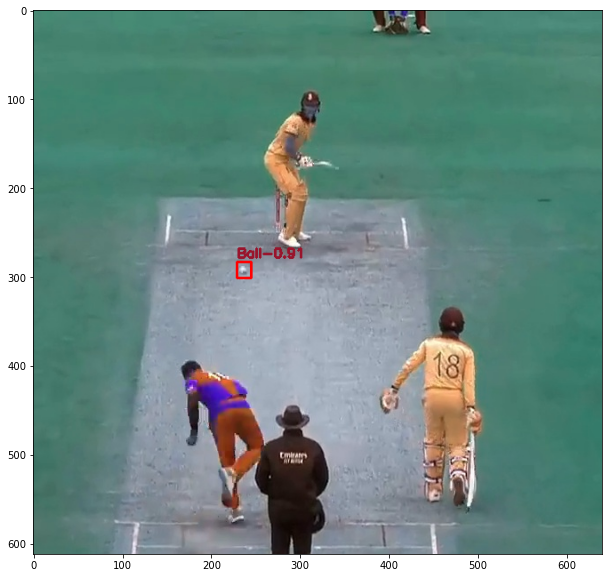

CPU times: total: 10.8 s
Wall time: 3.25 s


In [ ]:
%%time
ball_obj = pd.DataFrame()

cnt = 0
vid_name = ''
for i, fname in enumerate(dataset):
    # break
    if isinstance(fname, tuple):
        # print(1)
        path, im, im0s, vid_cap, s = fname
        # fname = os.path.basename(fname[0]).replace('.mp4', '') + f'__{i}'
        fname = os.path.basename(fname[0]).replace('.mp4', '') + f'__{cnt}'
        if not vid_name:
            vid_name = fname.split('__')[0]
        elif vid_name!=fname.split('__')[0]:
            vid_name = fname.split('__')[0]
            cnt = 0
    else:
        path = os.path.join(source, fname+'.jpg')
        im0s = cv2.imread(path)
    # print(f'{i} - {fname}')
    # if 'ICC_WC_2019_v1_19_21_sh_4__34' in fname:
    #     break
    # break
    # im_pre = getCroppedImage(im0s)
    im_pre = im0s.copy()
    #im = preprocess_img_yolo(im_pre, imgsz=imgsz, stride=stride, auto=pt, device='')
    if 'Ind_vs_Aus_2021' in fname:
        print(f'{i} - {fname} ====> cric_test')
        im = preprocess_img_yolo(im_pre, model_cric_test, imgsz=imgsz, stride=stride, auto=pt, device='')
        obj_list = getBallDetectYolo(
            im, model_cric_test, im_pre,
            conf_thres=0.25,  # confidence threshold
            iou_thres=0.45,  # NMS IOU threshold
            classes=None,  # filter by class: --class 0, or --class 0 2 3
            agnostic_nms=False,  # class-agnostic NMS
            max_det=1000,  # maximum detections per image
            top_obj_thresh = 0.50,
            ret_top_obj=False
            )
    else:
        print(f'{i} - {fname} ====> odi')
        im = preprocess_img_yolo(im_pre, model_odi, imgsz=imgsz, stride=stride, auto=pt, device='')
        obj_list = getBallDetectYolo(
            im, model_odi, im_pre,
            conf_thres=0.25,  # confidence threshold
            iou_thres=0.45,  # NMS IOU threshold
            classes=None,  # filter by class: --class 0, or --class 0 2 3
            agnostic_nms=False,  # class-agnostic NMS
            max_det=1000,  # maximum detections per image
            top_obj_thresh = 0.50,
            ret_top_obj=False
            )
    # obj_list.extend(obj_list)
    imc = im_pre.copy()
    vid = fname.split('__')[0]
    frm_no = fname.split('__')[1]
    if obj_list:
        obj_list2 = np.array(obj_list, dtype='object')
        ball_obj = pd.concat([ball_obj,
                           pd.DataFrame({
                               'fname': [fname]*len(obj_list),
                               'vid': [vid]*len(obj_list),
                               'frame': [frm_no]*len(obj_list),
                               'label': obj_list2[:,0],
                               'conf': obj_list2[:,2],
                               'bbox': obj_list2[:,1]
                               })
                           ])
        for b, obj in enumerate(obj_list):
            # break
            bbox = obj[1]
            p1 = (int(bbox[0]), int(bbox[1]))
            p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            cv2.rectangle(imc, p1, p2, (255,0,0), 2, 1)
            (x, y) = p1
            # draw a bounding box rectangle and label on the image
            # color = [int(c) for c in COLORS[b]]
            # b=9
            # color = [int(c) for c in COLORS[b]]
            # color = [255, 255, 255]
            color = [153, 20, 44]
            text = f'Ball-{round(obj[2], 3)}'
            cv2.putText(imc, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        # cv2.imwrite(os.path.join(test_pred_fld, f'{fname}.jpg'), imc)
        # break
    else:
        ball_obj = pd.concat([ball_obj,
                           pd.DataFrame({
                               'fname': [fname],
                               'vid': [vid],
                               'frame': [frm_no],
                               'label': [np.nan],
                               'conf': [np.nan],
                               'bbox': [np.nan]
                               })
                           ])
        color = [153, 20, 44]
        text = 'Ball not detected'
        cv2.putText(imc, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        # cv2.imwrite(os.path.join(test_pred_fld, f'{fname}.jpg'), imc)
        # plt.figure(figsize=(5, 4)); plt.imshow(imc); plt.show()
    # plt.figure(figsize=(5, 4)); plt.imshow(imc); plt.show()
    # cv2.imwrite(os.path.join(test_pred_fld, f'{fname}.jpg'), imc)
    plt_img(imc)
    cnt += 1
    # if i==5:
    #     break
#     if i%100==0:
#         ball_obj.to_excel(os.path.join(obj_det_base, 'csrt_data_v2/common_img_pitch_detect.xlsx'), index=False)
# # Saving final results to excel sheet
# ball_obj.to_excel(os.path.join(obj_det_base, 'csrt_data_v2/common_img_pitch_detect.xlsx'), index=False)

#### Pitch Detection

##### Folder paths

In [ ]:
yolo_base = r'D:\Tiger\Open_Innovation\cv\pychm\yolov5'
obj_det_base = r'D:\Tiger\Open_Innovation\cv\phase_2\obj_detection'

##### Loading model

In [ ]:
# device=''  # cuda device, i.e. 0 or 0,1,2,3 or cpu
# model = loadYoloModel(weights)#, device
imgsz = (640, 640)
pt = True # pt ==> pytorch
bs = 1
mdl_nm = 'pitch_detection_epoch_250_v2'
weights_pitch = os.path.join(yolo_base, f'{mdl_nm}/freeze_layers/weights/best.pt') # model.pt path(s)
model_pitch = loadYoloModel(weights_pitch)#, device
model_pitch.warmup(imgsz=(1 if pt else bs, 3, *imgsz))  # warmup
stride, names, pt = model_pitch.stride, model_pitch.names, model_pitch.pt
print(stride, names, pt)

imgsz=(640, 640)
print(imgsz)
imgsz = check_img_size(imgsz, s=stride)
print(imgsz)

YOLOv5  v6.1-289-g526e650 Python-3.9.12 torch-1.11.0 CPU



device -  cpu
weights -  D:\Tiger\Open_Innovation\cv\pychm\yolov5\pitch_detection_epoch_250_v2/freeze_layers/weights/best.pt


Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs


32 ['ball'] True
(640, 640)
[640, 640]


In [ ]:
# source = os.path.join(base_fld, vid_fld, f'{smp_vid}.mp4')
# dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
# source = os.path.join(obj_det_base, 'csrt_data_v2/common_data')
# dataset = [x.replace('.jpg', '') for x in os.listdir(source) if '.jpg' in x]
# dataset[:5]
source = os.path.join(fld0, mtp0)
dataset = [f'{fnm}']

##### Creating Prediction Folder

In [ ]:
# test_pred_fld = os.path.join(base_fld, 'ball_features/temp_pitch_tracking') # Top detection
# if not os.path.exists(test_pred_fld):
#     print(f'Creating dir - {test_pred_fld}')
#     os.mkdir(test_pred_fld)

##### Prediction

YOLOv5  v6.1-289-g526e650 Python-3.9.12 torch-1.11.0 CPU



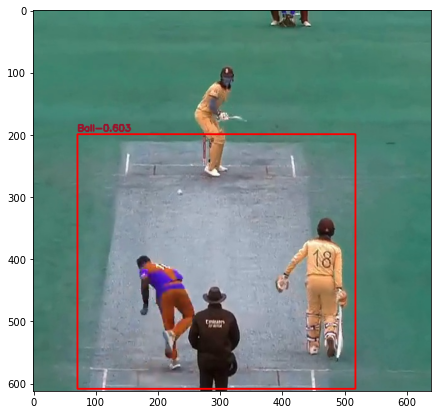

CPU times: total: 12.4 s
Wall time: 3.68 s


In [ ]:
%%time
pitch_obj = pd.DataFrame()

cnt = 0
vid_name = ''
for i, fname in enumerate(dataset):
    # break
    if isinstance(fname, tuple):
        # print(1)
        path, im, im0s, vid_cap, s = fname
        # fname = os.path.basename(fname[0]).replace('.mp4', '') + f'__{i}'
        fname = os.path.basename(fname[0]).replace('.mp4', '') + f'__{cnt}'
        if not vid_name:
            vid_name = fname.split('__')[0]
        elif vid_name!=fname.split('__')[0]:
            vid_name = fname.split('__')[0]
            cnt = 0
    else:
        path = os.path.join(source, fname+'.jpg')
        im0s = cv2.imread(path)
    # print(f'{i} - {fname}')
    # if 'ICC_WC_2019_v1_19_21_sh_4__34' in fname:
    #     break
    # break
    # im_pre = getCroppedImage(im0s)
    im_pre = im0s.copy()
    #im = preprocess_img_yolo(im_pre, imgsz=imgsz, stride=stride, auto=pt, device='')
    im = preprocess_img_yolo(im_pre, model_pitch, imgsz=imgsz, stride=stride, auto=pt, device='')
    obj_list = getBallDetectYolo(
        im, model_pitch, im_pre,
        conf_thres=0.25,  # confidence threshold
        iou_thres=0.45,  # NMS IOU threshold
        classes=None,  # filter by class: --class 0, or --class 0 2 3
        agnostic_nms=False,  # class-agnostic NMS
        max_det=1000,  # maximum detections per image
        top_obj_thresh = 0.50,
        ret_top_obj=False
        )
    # obj_list.extend(obj_list)
    imc = im_pre.copy()
    vid = fname.split('__')[0]
    frm_no = fname.split('__')[1]
    if obj_list:
        obj_list2 = np.array(obj_list, dtype='object')
        pitch_obj = pd.concat([pitch_obj,
                           pd.DataFrame({
                               'fname': [fname]*len(obj_list),
                               'vid': [vid]*len(obj_list),
                               'frame': [frm_no]*len(obj_list),
                               'label': obj_list2[:,0],
                               'conf': obj_list2[:,2],
                               'bbox': obj_list2[:,1]
                               })
                           ])
        for b, obj in enumerate(obj_list):
            # break
            bbox = obj[1]
            p1 = (int(bbox[0]), int(bbox[1]))
            p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            cv2.rectangle(imc, p1, p2, (255,0,0), 2, 1)
            (x, y) = p1
            # draw a bounding box rectangle and label on the image
            # color = [int(c) for c in COLORS[b]]
            # b=9
            # color = [int(c) for c in COLORS[b]]
            # color = [255, 255, 255]
            color = [153, 20, 44]
            text = f'Ball-{round(obj[2], 3)}'
            cv2.putText(imc, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        # cv2.imwrite(os.path.join(test_pred_fld, f'{fname}.jpg'), imc)
        # break
    else:
        pitch_obj = pd.concat([pitch_obj,
                           pd.DataFrame({
                               'fname': [fname],
                               'vid': [vid],
                               'frame': [frm_no],
                               'label': [np.nan],
                               'conf': [np.nan],
                               'bbox': [np.nan]
                               })
                           ])
        color = [153, 20, 44]
        text = 'Ball not detected'
        cv2.putText(imc, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        # cv2.imwrite(os.path.join(test_pred_fld, f'{fname}.jpg'), imc)
        # plt.figure(figsize=(5, 4)); plt.imshow(imc); plt.show()
    # plt.figure(figsize=(5, 4)); plt.imshow(imc); plt.show()
    plt_img(imc)
    # cv2.imwrite(os.path.join(test_pred_fld, f'{fname}.jpg'), imc)
    cnt += 1
    # if i==5:
    #     break
#     if i%100==0:
#         pitch_obj.to_excel(os.path.join(obj_det_base, 'csrt_data_v2/common_img_pitch_detect.xlsx'), index=False)
# # Saving final results to excel sheet
# pitch_obj.to_excel(os.path.join(obj_det_base, 'csrt_data_v2/common_img_pitch_detect.xlsx'), index=False)

#### Obj Detection - Yolo5x

##### Folder paths

In [26]:
yolo_base = '/content/gdrive/MyDrive/Open_Innov/Cricket_Analytics/src/prabakar_yolov5_models'
# yolo_base = r'D:\Tiger\Open_Innovation\cv\pychm\yolov5'
# obj_det_base = r'D:\Tiger\Open_Innovation\cv\phase_2\obj_detection'

##### Loading model

In [27]:
# device=''  # cuda device, i.e. 0 or 0,1,2,3 or cpu
# model = loadYoloModel(weights)#, device
imgsz = (1920, 1920) #(640, 640)
pt = True # pt ==> pytorch
bs = 1
# ## Model for ODI
# mdl_nm = 'cric_ball_detection2'
# weights_odi = os.path.join(yolo_base, f'{mdl_nm}/freeze_layers/weights/best.pt') # model.pt path(s)
# # weights_odi = os.path.join(yolo_base, 'cric_ball_detection2/freeze_layers/weights/best.pt') # model.pt path(s)
# model_odi = loadYoloModel(weights_odi)#, device
# model_odi.warmup(imgsz=(1 if pt else bs, 3, *imgsz))  # warmup
# ## Model for Cric Test
# mdl_nm = 'cric_ball_detection_cric_test_v1'
# weights_cric_test = os.path.join(yolo_base, f'{mdl_nm}/freeze_layers/weights/best.pt') # model.pt path(s)
# # weights_cric_test = os.path.join(yolo_base, 'cric_ball_detection_cric_test_v1/freeze_layers/weights/best.pt') # model.pt path(s)
# model_cric_test = loadYoloModel(weights_cric_test)#, device

model_5x = loadYoloModel('yolov5x.pt')#, device
model_5x.warmup(imgsz=(1 if pt else bs, 3, *imgsz))  # warmup
stride, names, pt = model_5x.stride, model_5x.names, model_5x.pt
print(stride, names, pt)

imgsz = (1920, 1920) #(640, 640)
print(imgsz)
imgsz = check_img_size(imgsz, s=stride)
print(imgsz)

INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



device -  cuda:0
weights -  yolov5x.pt


INFO:yolov5:Downloading https://github.com/ultralytics/yolov5/releases/download/v6.1/yolov5x.pt to yolov5x.pt...


  0%|          | 0.00/166M [00:00<?, ?B/s]

INFO:yolov5:

INFO:yolov5:Fusing layers... 
Fusing layers... 
INFO:yolov5:YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


32 ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'] True
(1920, 1920)
[1920, 1920]


In [63]:
# vfname = 'cric_test'
vfname = 'odi'
# vfname = 'bat_886_889_ball_output_best'
source = os.path.join(fld0, vfname)
dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
# source = os.path.join(obj_det_base, 'csrt_data_v2/common_data')
# dataset = [x.replace('.jpg', '') for x in os.listdir(source) if '.jpg' in x]
# dataset[:5]
# source = os.path.join(fld0, mtp0)
# dataset = im_list[:10]   #[f'{fnm}']
# print('No. of images', len(dataset))
# dataset[:5]

##### Creating Prediction Folder

In [64]:
vfname

'odi'

In [65]:
test_pred_fld_0 = os.path.join(base_fld, 'exp_1')
res_nm = f'{vfname}_v1'
test_pred_fld = os.path.join(test_pred_fld_0, res_nm)

if not os.path.exists(test_pred_fld_0):
    print(f'Creating dir - {test_pred_fld_0}')
    os.mkdir(test_pred_fld_0)
if not os.path.exists(test_pred_fld):
    print(f'Creating dir - {test_pred_fld}')
    os.mkdir(test_pred_fld)

Creating dir - /content/gdrive/MyDrive/Open_Innov/Cricket_Analytics/Cricket Analytics/Prabakar/obj_detection/instance_seg/exp_1/odi_v1


##### Prediction

In [66]:
yl_lbl = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [67]:
%%time
inst_obj = pd.DataFrame()

cnt = 0
vid_name = ''
for i, fname in enumerate(dataset):
    # break
    if isinstance(fname, tuple):
        # print(1)
        path, im, im0s, vid_cap, s = fname
        # fname = os.path.basename(fname[0]).replace('.mp4', '') + f'__{i}'
        fname = os.path.basename(fname[0]).replace('.mp4', '') + f'__{cnt}'
        if not vid_name:
            vid_name = fname.split('__')[0]
        elif vid_name!=fname.split('__')[0]:
            vid_name = fname.split('__')[0]
            cnt = 0
    else:
        path = os.path.join(source, fname+'.jpg')
        im0s = cv2.imread(path)
    # print(f'{i} - {fname}')
    # if 'ICC_WC_2019_v1_19_21_sh_4__34' in fname:
    #     break
    # break
    # im_pre = getCroppedImage(im0s, scr_thresh=0.10, width_thresh=1/3)
    # im_pre = im0s.copy()
    mp = 3
    im_pre = cv2.resize(im0s, (im0s.shape[1]*mp, im0s.shape[0]*mp))
    #im = preprocess_img_yolo(im_pre, imgsz=imgsz, stride=stride, auto=pt, device='')
    print(f'{i} - {fname}')
    im = preprocess_img_yolo(im_pre, model_5x, imgsz=imgsz, stride=stride, auto=pt, device='')
    obj_list = getBallDetectYolo(
        im, model_5x, im_pre,
        conf_thres=0.25,  # confidence threshold
        iou_thres=0.45,  # NMS IOU threshold
        classes=None,  # filter by class: --class 0, or --class 0 2 3
        agnostic_nms=False,  # class-agnostic NMS
        max_det=1000,  # maximum detections per image
        top_obj_thresh = 0.25,
        ret_top_obj=False
        )
    # obj_list.extend(obj_list)
    imc = im_pre.copy()
    vid = fname.split('__')[0]
    frm_no = fname.split('__')[1]
    if obj_list:
        obj_list2 = np.array(obj_list, dtype='object')
        inst_obj = pd.concat([inst_obj,
                           pd.DataFrame({
                               'fname': [fname]*len(obj_list),
                               'vid': [vid]*len(obj_list),
                               'frame': [frm_no]*len(obj_list),
                               'label': obj_list2[:,0],
                               'cls': [yl_lbl[x] for x in obj_list2[:,0]],
                               'conf': obj_list2[:,2],
                               'bbox': obj_list2[:,1]
                               })
                           ], ignore_index=True, sort=False)
        for b, obj in enumerate(obj_list):
            # break
            bbox = obj[1]
            p1 = (int(bbox[0]), int(bbox[1]))
            p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            cv2.rectangle(imc, p1, p2, (255,0,0), 2, 1)
            (x, y) = p1
            # draw a bounding box rectangle and label on the image
            # color = [int(c) for c in COLORS[b]]
            # b=9
            # color = [int(c) for c in COLORS[b]]
            # color = [255, 255, 255]
            color = [153, 20, 44]
            text = f'{yl_lbl[obj[0]]}-{round(obj[2], 3)}'
            cv2.putText(imc, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 4)
        # cv2.imwrite(os.path.join(test_pred_fld, f'{fname}.jpg'), imc)
        # break
    else:
        inst_obj = pd.concat([inst_obj,
                           pd.DataFrame({
                               'fname': [fname],
                               'vid': [vid],
                               'frame': [frm_no],
                               'label': [np.nan],
                               'cls':  [np.nan],
                               'conf': [np.nan],
                               'bbox': [np.nan]
                               })
                           ], ignore_index=True, sort=False)
        color = [153, 20, 44]
        text = 'Ball not detected'
        cv2.putText(imc, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 4)
        # cv2.imwrite(os.path.join(test_pred_fld, f'{fname}.jpg'), imc)
        # plt.figure(figsize=(5, 4)); plt.imshow(imc); plt.show()
    # plt.figure(figsize=(5, 4)); plt.imshow(imc); plt.show()
    cv2.imwrite(os.path.join(test_pred_fld, f'{fname}.jpg'), imc)
    # plt_img(imc)
    cnt += 1
    # break
    # if i==5:
    #     break
    if i%50==0:
        # plt_img(imc)
        inst_obj.to_excel(os.path.join(test_pred_fld_0, f'{res_nm}.xlsx'), index=False)
# Saving final results to excel sheet
inst_obj.to_excel(os.path.join(test_pred_fld_0, f'{res_nm}.xlsx'), index=False)

INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



0 - ICC_WC_2019_v1_0_2_sh_1__13.jpg__0


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



1 - ICC_WC_2019_v1_101_103_sh_14__11.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



2 - ICC_WC_2019_v1_101_103_sh_14__12.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



3 - ICC_WC_2019_v1_101_103_sh_14__13.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



4 - ICC_WC_2019_v1_101_103_sh_14__14.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



5 - ICC_WC_2019_v1_101_103_sh_14__15.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



6 - ICC_WC_2019_v1_101_103_sh_14__16.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



7 - ICC_WC_2019_v1_101_103_sh_14__17.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



8 - ICC_WC_2019_v1_101_103_sh_14__18.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



9 - ICC_WC_2019_v1_101_103_sh_14__19.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



10 - ICC_WC_2019_v1_101_103_sh_14__20.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



11 - ICC_WC_2019_v1_101_103_sh_14__21.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



12 - ICC_WC_2019_v1_101_103_sh_14__22.jpg__11


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



13 - ICC_WC_2019_v1_101_103_sh_14__23.jpg__12


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



14 - ICC_WC_2019_v1_101_103_sh_14__24.jpg__13


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



15 - ICC_WC_2019_v1_101_103_sh_14__25.jpg__14


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



16 - ICC_WC_2019_v1_101_103_sh_14__26.jpg__15


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



17 - ICC_WC_2019_v1_101_103_sh_14__27.jpg__16


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



18 - ICC_WC_2019_v1_109_111_sh_15__10.jpg__17


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



19 - ICC_WC_2019_v1_109_111_sh_15__11.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



20 - ICC_WC_2019_v1_109_111_sh_15__12.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



21 - ICC_WC_2019_v1_109_111_sh_15__13.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



22 - ICC_WC_2019_v1_109_111_sh_15__14.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



23 - ICC_WC_2019_v1_109_111_sh_15__15.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



24 - ICC_WC_2019_v1_109_111_sh_15__16.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



25 - ICC_WC_2019_v1_109_111_sh_15__17.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



26 - ICC_WC_2019_v1_109_111_sh_15__18.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



27 - ICC_WC_2019_v1_109_111_sh_15__7.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



28 - ICC_WC_2019_v1_109_111_sh_15__8.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



29 - ICC_WC_2019_v1_109_111_sh_15__9.jpg__11


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



30 - ICC_WC_2019_v1_115_118_sh_16__28.jpg__12


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



31 - ICC_WC_2019_v1_115_118_sh_16__29.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



32 - ICC_WC_2019_v1_115_118_sh_16__30.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



33 - ICC_WC_2019_v1_115_118_sh_16__31.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



34 - ICC_WC_2019_v1_115_118_sh_16__32.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



35 - ICC_WC_2019_v1_115_118_sh_16__33.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



36 - ICC_WC_2019_v1_115_118_sh_16__34.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



37 - ICC_WC_2019_v1_115_118_sh_16__35.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



38 - ICC_WC_2019_v1_115_118_sh_16__36.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



39 - ICC_WC_2019_v1_115_118_sh_16__39.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



40 - ICC_WC_2019_v1_115_118_sh_16__40.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



41 - ICC_WC_2019_v1_115_118_sh_16__41.jpg__11


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



42 - ICC_WC_2019_v1_115_118_sh_16__42.jpg__12


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



43 - ICC_WC_2019_v1_115_118_sh_16__43.jpg__13


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



44 - ICC_WC_2019_v1_115_118_sh_16__44.jpg__14


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



45 - ICC_WC_2019_v1_129_131_sh_17__1.jpg__15


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



46 - ICC_WC_2019_v1_129_131_sh_17__10.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



47 - ICC_WC_2019_v1_129_131_sh_17__11.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



48 - ICC_WC_2019_v1_129_131_sh_17__12.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



49 - ICC_WC_2019_v1_129_131_sh_17__13.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



50 - ICC_WC_2019_v1_129_131_sh_17__2.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



51 - ICC_WC_2019_v1_129_131_sh_17__3.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



52 - ICC_WC_2019_v1_129_131_sh_17__4.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



53 - ICC_WC_2019_v1_129_131_sh_17__5.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



54 - ICC_WC_2019_v1_129_131_sh_17__6.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



55 - ICC_WC_2019_v1_129_131_sh_17__7.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



56 - ICC_WC_2019_v1_129_131_sh_17__8.jpg__11


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



57 - ICC_WC_2019_v1_129_131_sh_17__9.jpg__12


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



58 - ICC_WC_2019_v1_138_140_sh_18__0.jpg__13


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



59 - ICC_WC_2019_v1_138_140_sh_18__1.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



60 - ICC_WC_2019_v1_138_140_sh_18__2.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



61 - ICC_WC_2019_v1_138_140_sh_18__3.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



62 - ICC_WC_2019_v1_138_140_sh_18__4.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



63 - ICC_WC_2019_v1_138_140_sh_18__5.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



64 - ICC_WC_2019_v1_151_153_sh_19__24.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



65 - ICC_WC_2019_v1_151_153_sh_19__25.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



66 - ICC_WC_2019_v1_151_153_sh_19__26.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



67 - ICC_WC_2019_v1_151_153_sh_19__27.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



68 - ICC_WC_2019_v1_151_153_sh_19__28.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



69 - ICC_WC_2019_v1_151_153_sh_19__29.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



70 - ICC_WC_2019_v1_151_153_sh_19__30.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



71 - ICC_WC_2019_v1_151_153_sh_19__31.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



72 - ICC_WC_2019_v1_151_153_sh_19__32.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



73 - ICC_WC_2019_v1_164_166_sh_20__10.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



74 - ICC_WC_2019_v1_164_166_sh_20__11.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



75 - ICC_WC_2019_v1_164_166_sh_20__12.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



76 - ICC_WC_2019_v1_164_166_sh_20__13.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



77 - ICC_WC_2019_v1_164_166_sh_20__14.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



78 - ICC_WC_2019_v1_169_171_sh_21__26.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



79 - ICC_WC_2019_v1_169_171_sh_21__27.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



80 - ICC_WC_2019_v1_169_171_sh_21__28.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



81 - ICC_WC_2019_v1_169_171_sh_21__29.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



82 - ICC_WC_2019_v1_169_171_sh_21__30.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



83 - ICC_WC_2019_v1_169_171_sh_21__31.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



84 - ICC_WC_2019_v1_169_171_sh_21__32.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



85 - ICC_WC_2019_v1_169_171_sh_21__33.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



86 - ICC_WC_2019_v1_169_171_sh_21__34.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



87 - ICC_WC_2019_v1_169_171_sh_21__35.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



88 - ICC_WC_2019_v1_169_171_sh_21__36.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



89 - ICC_WC_2019_v1_169_171_sh_21__37.jpg__11


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



90 - ICC_WC_2019_v1_176_178_sh_22__26.jpg__12


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



91 - ICC_WC_2019_v1_176_178_sh_22__27.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



92 - ICC_WC_2019_v1_176_178_sh_22__28.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



93 - ICC_WC_2019_v1_176_178_sh_22__29.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



94 - ICC_WC_2019_v1_176_178_sh_22__30.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



95 - ICC_WC_2019_v1_176_178_sh_22__31.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



96 - ICC_WC_2019_v1_176_178_sh_22__32.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



97 - ICC_WC_2019_v1_176_178_sh_22__33.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



98 - ICC_WC_2019_v1_176_178_sh_22__34.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



99 - ICC_WC_2019_v1_176_178_sh_22__35.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



100 - ICC_WC_2019_v1_176_178_sh_22__36.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



101 - ICC_WC_2019_v1_176_178_sh_22__37.jpg__11


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



102 - ICC_WC_2019_v1_190_192_sh_23__10.jpg__12


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



103 - ICC_WC_2019_v1_190_192_sh_23__11.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



104 - ICC_WC_2019_v1_190_192_sh_23__12.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



105 - ICC_WC_2019_v1_190_192_sh_23__13.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



106 - ICC_WC_2019_v1_190_192_sh_23__14.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



107 - ICC_WC_2019_v1_190_192_sh_23__15.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



108 - ICC_WC_2019_v1_190_192_sh_23__9.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



109 - ICC_WC_2019_v1_197_199_sh_24__20.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



110 - ICC_WC_2019_v1_197_199_sh_24__21.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



111 - ICC_WC_2019_v1_197_199_sh_24__22.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



112 - ICC_WC_2019_v1_197_199_sh_24__23.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



113 - ICC_WC_2019_v1_197_199_sh_24__24.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



114 - ICC_WC_2019_v1_197_199_sh_24__25.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



115 - ICC_WC_2019_v1_197_199_sh_24__26.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



116 - ICC_WC_2019_v1_19_21_sh_4__24.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



117 - ICC_WC_2019_v1_19_21_sh_4__25.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



118 - ICC_WC_2019_v1_19_21_sh_4__26.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



119 - ICC_WC_2019_v1_19_21_sh_4__27.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



120 - ICC_WC_2019_v1_19_21_sh_4__28.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



121 - ICC_WC_2019_v1_19_21_sh_4__29.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



122 - ICC_WC_2019_v1_19_21_sh_4__30.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



123 - ICC_WC_2019_v1_19_21_sh_4__31.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



124 - ICC_WC_2019_v1_19_21_sh_4__32.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



125 - ICC_WC_2019_v1_19_21_sh_4__33.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



126 - ICC_WC_2019_v1_204_206_sh_25__23.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



127 - ICC_WC_2019_v1_204_206_sh_25__24.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



128 - ICC_WC_2019_v1_204_206_sh_25__25.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



129 - ICC_WC_2019_v1_204_206_sh_25__26.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



130 - ICC_WC_2019_v1_204_206_sh_25__27.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



131 - ICC_WC_2019_v1_204_206_sh_25__28.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



132 - ICC_WC_2019_v1_204_206_sh_25__29.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



133 - ICC_WC_2019_v1_204_206_sh_25__30.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



134 - ICC_WC_2019_v1_211_213_sh_26__10.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



135 - ICC_WC_2019_v1_211_213_sh_26__11.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



136 - ICC_WC_2019_v1_211_213_sh_26__12.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



137 - ICC_WC_2019_v1_211_213_sh_26__4.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



138 - ICC_WC_2019_v1_211_213_sh_26__5.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



139 - ICC_WC_2019_v1_211_213_sh_26__6.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



140 - ICC_WC_2019_v1_211_213_sh_26__7.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



141 - ICC_WC_2019_v1_211_213_sh_26__8.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



142 - ICC_WC_2019_v1_211_213_sh_26__9.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



143 - ICC_WC_2019_v1_217_219_sh_27__15.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



144 - ICC_WC_2019_v1_217_219_sh_27__16.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



145 - ICC_WC_2019_v1_217_219_sh_27__17.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



146 - ICC_WC_2019_v1_217_219_sh_27__18.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



147 - ICC_WC_2019_v1_217_219_sh_27__19.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



148 - ICC_WC_2019_v1_217_219_sh_27__20.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



149 - ICC_WC_2019_v1_226_228_sh_28__18.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



150 - ICC_WC_2019_v1_226_228_sh_28__19.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



151 - ICC_WC_2019_v1_226_228_sh_28__20.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



152 - ICC_WC_2019_v1_226_228_sh_28__21.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



153 - ICC_WC_2019_v1_226_228_sh_28__22.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



154 - ICC_WC_2019_v1_226_228_sh_28__23.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



155 - ICC_WC_2019_v1_226_228_sh_28__24.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



156 - ICC_WC_2019_v1_226_228_sh_28__25.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



157 - ICC_WC_2019_v1_226_228_sh_28__26.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



158 - ICC_WC_2019_v1_226_228_sh_28__27.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



159 - ICC_WC_2019_v1_226_228_sh_28__28.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



160 - ICC_WC_2019_v1_226_228_sh_28__29.jpg__11


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



161 - ICC_WC_2019_v1_226_228_sh_28__30.jpg__12


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



162 - ICC_WC_2019_v1_226_228_sh_28__31.jpg__13


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



163 - ICC_WC_2019_v1_226_228_sh_28__33.jpg__14


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



164 - ICC_WC_2019_v2_15_17_sh_3__0.jpg__15


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



165 - ICC_WC_2019_v2_15_17_sh_3__1.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



166 - ICC_WC_2019_v2_15_17_sh_3__2.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



167 - ICC_WC_2019_v2_70_72_sh_11__26.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



168 - ICC_WC_2019_v2_70_72_sh_11__27.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



169 - ICC_WC_2019_v2_70_72_sh_11__28.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



170 - ICC_WC_2019_v2_70_72_sh_11__29.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



171 - ICC_WC_2019_v2_70_72_sh_11__30.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



172 - ICC_WC_2019_v2_70_72_sh_11__31.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



173 - ICC_WC_2019_v2_70_72_sh_11__32.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



174 - ICC_WC_2019_v2_70_72_sh_11__33.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



175 - ICC_WC_2019_v2_70_72_sh_11__34.jpg__8


176 - ICC_WC_2019_v2_70_72_sh_11__35.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



177 - ICC_WC_2019_v2_70_72_sh_11__36.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



178 - ICC_WC_2019_v2_70_72_sh_11__37.jpg__11


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



179 - ICC_WC_2019_v3_0_2_sh_1__21.jpg__12


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



180 - ICC_WC_2019_v3_0_2_sh_1__22.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



181 - ICC_WC_2019_v3_100_102_sh_13__29.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



182 - ICC_WC_2019_v3_100_102_sh_13__30.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



183 - ICC_WC_2019_v3_100_102_sh_13__31.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



184 - ICC_WC_2019_v3_100_102_sh_13__32.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



185 - ICC_WC_2019_v3_100_102_sh_13__33.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



186 - ICC_WC_2019_v3_100_102_sh_13__34.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



187 - ICC_WC_2019_v3_100_102_sh_13__35.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



188 - ICC_WC_2019_v3_107_109_sh_14__29.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



189 - ICC_WC_2019_v3_107_109_sh_14__30.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



190 - ICC_WC_2019_v3_107_109_sh_14__31.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



191 - ICC_WC_2019_v3_107_109_sh_14__32.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



192 - ICC_WC_2019_v3_107_109_sh_14__33.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



193 - ICC_WC_2019_v3_107_109_sh_14__34.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



194 - ICC_WC_2019_v3_107_109_sh_14__35.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



195 - ICC_WC_2019_v3_107_109_sh_14__36.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



196 - ICC_WC_2019_v3_114_116_sh_15__33.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



197 - ICC_WC_2019_v3_114_116_sh_15__34.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



198 - ICC_WC_2019_v3_114_116_sh_15__35.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



199 - ICC_WC_2019_v3_114_116_sh_15__36.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



200 - ICC_WC_2019_v3_123_125_sh_16__25.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



201 - ICC_WC_2019_v3_123_125_sh_16__26.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



202 - ICC_WC_2019_v3_130_132_sh_17__29.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



203 - ICC_WC_2019_v3_137_140_sh_18__56.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



204 - ICC_WC_2019_v3_137_140_sh_18__57.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



205 - ICC_WC_2019_v3_137_140_sh_18__58.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



206 - ICC_WC_2019_v3_137_140_sh_18__59.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



207 - ICC_WC_2019_v3_137_140_sh_18__60.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



208 - ICC_WC_2019_v3_137_140_sh_18__61.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



209 - ICC_WC_2019_v3_137_140_sh_18__62.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



210 - ICC_WC_2019_v3_137_140_sh_18__63.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



211 - ICC_WC_2019_v3_137_140_sh_18__64.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



212 - ICC_WC_2019_v3_137_140_sh_18__65.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



213 - ICC_WC_2019_v3_145_147_sh_19__30.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



214 - ICC_WC_2019_v3_145_147_sh_19__31.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



215 - ICC_WC_2019_v3_145_147_sh_19__32.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



216 - ICC_WC_2019_v3_145_147_sh_19__33.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



217 - ICC_WC_2019_v3_145_147_sh_19__34.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



218 - ICC_WC_2019_v3_181_183_sh_23__19.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



219 - ICC_WC_2019_v4_110_112_sh_17__21.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



220 - ICC_WC_2019_v4_110_112_sh_17__22.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



221 - ICC_WC_2019_v4_110_112_sh_17__23.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



222 - ICC_WC_2019_v4_110_112_sh_17__24.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



223 - ICC_WC_2019_v4_110_112_sh_17__25.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



224 - ICC_WC_2019_v4_110_112_sh_17__26.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



225 - ICC_WC_2019_v4_116_118_sh_18__30.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



226 - ICC_WC_2019_v4_116_118_sh_18__31.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



227 - ICC_WC_2019_v4_116_118_sh_18__32.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



228 - ICC_WC_2019_v4_116_118_sh_18__33.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



229 - ICC_WC_2019_v4_116_118_sh_18__34.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



230 - ICC_WC_2019_v4_116_118_sh_18__35.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



231 - ICC_WC_2019_v4_116_118_sh_18__36.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



232 - ICC_WC_2019_v4_116_118_sh_18__37.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



233 - ICC_WC_2019_v4_116_118_sh_18__38.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



234 - ICC_WC_2019_v4_116_118_sh_18__39.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



235 - ICC_WC_2019_v4_116_118_sh_18__40.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



236 - ICC_WC_2019_v4_116_118_sh_18__41.jpg__11


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



237 - ICC_WC_2019_v4_116_118_sh_18__42.jpg__12


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



238 - ICC_WC_2019_v4_121_123_sh_19__29.jpg__13


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



239 - ICC_WC_2019_v4_121_123_sh_19__30.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



240 - ICC_WC_2019_v4_121_123_sh_19__31.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



241 - ICC_WC_2019_v4_121_123_sh_19__32.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



242 - ICC_WC_2019_v4_121_123_sh_19__33.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



243 - ICC_WC_2019_v4_121_123_sh_19__34.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



244 - ICC_WC_2019_v4_121_123_sh_19__35.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



245 - ICC_WC_2019_v4_121_123_sh_19__36.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



246 - ICC_WC_2019_v4_121_123_sh_19__37.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



247 - ICC_WC_2019_v4_121_123_sh_19__38.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



248 - ICC_WC_2019_v4_121_123_sh_19__39.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



249 - ICC_WC_2019_v4_121_123_sh_19__40.jpg__11


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



250 - ICC_WC_2019_v4_126_128_sh_20__32.jpg__12


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



251 - ICC_WC_2019_v4_126_128_sh_20__33.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



252 - ICC_WC_2019_v4_126_128_sh_20__34.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



253 - ICC_WC_2019_v4_126_128_sh_20__35.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



254 - ICC_WC_2019_v4_126_128_sh_20__36.jpg__4


255 - ICC_WC_2019_v4_126_128_sh_20__37.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



256 - ICC_WC_2019_v4_126_128_sh_20__38.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



257 - ICC_WC_2019_v4_126_128_sh_20__39.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



258 - ICC_WC_2019_v4_126_128_sh_20__40.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



259 - ICC_WC_2019_v4_132_134_sh_21__20.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



260 - ICC_WC_2019_v4_132_134_sh_21__21.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



261 - ICC_WC_2019_v4_132_134_sh_21__22.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



262 - ICC_WC_2019_v4_132_134_sh_21__23.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



263 - ICC_WC_2019_v4_132_134_sh_21__24.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



264 - ICC_WC_2019_v4_132_134_sh_21__25.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



265 - ICC_WC_2019_v4_132_134_sh_21__26.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



266 - ICC_WC_2019_v4_132_134_sh_21__27.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



267 - ICC_WC_2019_v4_132_134_sh_21__28.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



268 - ICC_WC_2019_v4_132_134_sh_21__29.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



269 - ICC_WC_2019_v4_132_134_sh_21__30.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



270 - ICC_WC_2019_v4_137_139_sh_22__23.jpg__11


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



271 - ICC_WC_2019_v4_137_139_sh_22__24.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



272 - ICC_WC_2019_v4_137_139_sh_22__25.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



273 - ICC_WC_2019_v4_142_144_sh_23__26.jpg__3


274 - ICC_WC_2019_v4_142_144_sh_23__27.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



275 - ICC_WC_2019_v4_142_144_sh_23__28.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



276 - ICC_WC_2019_v4_142_144_sh_23__29.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



277 - ICC_WC_2019_v4_142_144_sh_23__30.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



278 - ICC_WC_2019_v5_102_104_sh_14__32.jpg__5


279 - ICC_WC_2019_v5_102_104_sh_14__33.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



280 - ICC_WC_2019_v5_102_104_sh_14__34.jpg__2


YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



281 - ICC_WC_2019_v5_102_104_sh_14__35.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



282 - ICC_WC_2019_v5_102_104_sh_14__36.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



283 - ICC_WC_2019_v5_102_104_sh_14__37.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



284 - ICC_WC_2019_v5_102_104_sh_14__38.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



285 - ICC_WC_2019_v5_102_104_sh_14__39.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



286 - ICC_WC_2019_v5_108_110_sh_15__19.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



287 - ICC_WC_2019_v5_108_110_sh_15__20.jpg__1


YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



288 - ICC_WC_2019_v5_108_110_sh_15__21.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



289 - ICC_WC_2019_v5_108_110_sh_15__22.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



290 - ICC_WC_2019_v5_108_110_sh_15__23.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



291 - ICC_WC_2019_v5_108_110_sh_15__24.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



292 - ICC_WC_2019_v5_108_110_sh_15__25.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



293 - ICC_WC_2019_v5_108_110_sh_15__26.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



294 - ICC_WC_2019_v5_108_110_sh_15__27.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



295 - ICC_WC_2019_v5_108_110_sh_15__28.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



296 - ICC_WC_2019_v5_114_116_sh_16__34.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



297 - ICC_WC_2019_v5_114_116_sh_16__44.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



298 - ICC_WC_2019_v5_11_13_sh_1__22.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



299 - ICC_WC_2019_v5_126_128_sh_17__37.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



300 - ICC_WC_2019_v5_126_128_sh_17__38.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



301 - ICC_WC_2019_v5_126_128_sh_17__39.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



302 - ICC_WC_2019_v5_126_128_sh_17__40.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



303 - ICC_WC_2019_v5_126_128_sh_17__41.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



304 - ICC_WC_2019_v5_126_128_sh_17__42.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



305 - ICC_WC_2019_v5_126_128_sh_17__47.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



306 - ICC_WC_2019_v5_134_136_sh_18__45.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



307 - ICC_WC_2019_v5_143_145_sh_19__25.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



308 - ICC_WC_2019_v5_143_145_sh_19__26.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



309 - ICC_WC_2019_v5_143_145_sh_19__27.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



310 - ICC_WC_2019_v5_143_145_sh_19__28.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



311 - ICC_WC_2019_v5_143_145_sh_19__35.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



312 - ICC_WC_2019_v5_151_154_sh_20__54.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



313 - ICC_WC_2019_v5_151_154_sh_20__55.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



314 - ICC_WC_2019_v5_151_154_sh_20__56.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



315 - ICC_WC_2019_v5_151_154_sh_20__57.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



316 - ICC_WC_2019_v5_151_154_sh_20__58.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



317 - ICC_WC_2019_v5_151_154_sh_20__59.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



318 - ICC_WC_2019_v5_151_154_sh_20__60.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



319 - ICC_WC_2019_v5_151_154_sh_20__61.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



320 - ICC_WC_2019_v5_151_154_sh_20__62.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



321 - ICC_WC_2019_v5_151_154_sh_20__63.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



322 - ICC_WC_2019_v5_151_154_sh_20__64.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



323 - ICC_WC_2019_v5_151_154_sh_20__65.jpg__11


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



324 - ICC_WC_2019_v5_159_161_sh_21__17.jpg__12


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



325 - ICC_WC_2019_v5_159_161_sh_21__18.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



326 - ICC_WC_2019_v5_159_161_sh_21__19.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



327 - ICC_WC_2019_v5_159_161_sh_21__20.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



328 - ICC_WC_2019_v5_159_161_sh_21__21.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



329 - ICC_WC_2019_v5_159_161_sh_21__22.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



330 - ICC_WC_2019_v5_159_161_sh_21__23.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



331 - ICC_WC_2019_v5_159_161_sh_21__24.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



332 - ICC_WC_2019_v5_159_161_sh_21__25.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



333 - ICC_WC_2019_v5_159_161_sh_21__26.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



334 - ICC_WT20_2016_v10_18_19_sh_3__19.jpg__10


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



335 - ICC_WT20_2016_v10_18_19_sh_3__20.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



336 - ICC_WT20_2016_v1_25_26_sh_4__19.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



337 - ICC_WT20_2016_v1_25_26_sh_4__20.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



338 - ICC_WT20_2016_v1_25_26_sh_4__21.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



339 - ICC_WT20_2016_v1_25_26_sh_4__22.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



340 - ICC_WT20_2016_v1_25_26_sh_4__23.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



341 - ICC_WT20_2016_v1_25_26_sh_4__24.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



342 - ICC_WT20_2016_v2_37_39_sh_5__26.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



343 - ICC_WT20_2016_v2_37_39_sh_5__27.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



344 - ICC_WT20_2016_v2_37_39_sh_5__28.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



345 - ICC_WT20_2016_v2_37_39_sh_5__29.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



346 - ICC_WT20_2016_v2_37_39_sh_5__30.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



347 - ICC_WT20_2016_v2_37_39_sh_5__31.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



348 - ICC_WT20_2016_v2_37_39_sh_5__32.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



349 - ICC_WT20_2016_v2_37_39_sh_5__33.jpg__7


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



350 - ICC_WT20_2016_v2_37_39_sh_5__34.jpg__8


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



351 - ICC_WT20_2016_v2_37_39_sh_5__35.jpg__9


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



352 - ICC_WT20_2016_v3_60_61_sh_10__10.jpg__10


353 - ICC_WT20_2016_v3_60_61_sh_10__11.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



354 - ICC_WT20_2016_v3_60_61_sh_10__12.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



355 - ICC_WT20_2016_v3_60_61_sh_10__7.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



356 - ICC_WT20_2016_v3_60_61_sh_10__8.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



357 - ICC_WT20_2016_v3_60_61_sh_10__9.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



358 - ICC_WT20_2016_v4_57_58_sh_8__10.jpg__6


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



359 - ICC_WT20_2016_v4_57_58_sh_8__11.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



360 - ICC_WT20_2016_v4_57_58_sh_8__12.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



361 - ICC_WT20_2016_v4_57_58_sh_8__8.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



362 - ICC_WT20_2016_v4_57_58_sh_8__9.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



363 - ICC_WT20_2016_v5_106_107_sh_17__5.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



364 - ICC_WT20_2016_v5_106_107_sh_17__6.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



365 - ICC_WT20_2016_v5_106_107_sh_17__7.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



366 - ICC_WT20_2016_v5_106_107_sh_17__8.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



367 - ICC_WT20_2016_v5_106_107_sh_17__9.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



368 - ICC_WT20_2016_v9_11_12_sh_2__18.jpg__5


369 - ICC_WT20_2016_v9_11_12_sh_2__19.jpg__1


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



370 - ICC_WT20_2016_v9_11_12_sh_2__20.jpg__2


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



371 - ICC_WT20_2016_v9_11_12_sh_2__21.jpg__3


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



372 - ICC_WT20_2016_v9_11_12_sh_2__22.jpg__4


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



373 - ICC_WT20_2016_v9_11_12_sh_2__23.jpg__5


INFO:yolov5:YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



374 - ICC_WT20_2016_v9_11_12_sh_2__24.jpg__6


CPU times: user 3min 46s, sys: 15.1 s, total: 4min 1s
Wall time: 4min 53s


In [73]:
imc.shape

(1836, 1920, 3)

In [68]:
inst_obj['cls'].value_counts()

person            1733
baseball glove     229
baseball bat        87
sports ball         48
handbag             42
fire hydrant        29
tennis racket       24
suitcase            17
bicycle             17
bottle              15
skateboard          12
skis                12
toothbrush          12
backpack            11
boat                 9
remote               8
clock                8
chair                8
sheep                7
dog                  7
motorcycle           6
umbrella             5
car                  5
vase                 4
airplane             3
bird                 3
traffic light        2
parking meter        1
snowboard            1
cell phone           1
train                1
bench                1
frisbee              1
kite                 1
truck                1
tie                  1
Name: cls, dtype: int64

In [69]:
res_nm

'odi_v1'

In [99]:
# tres_nm = 'odi_v1'
tres_nm = 'cric_test_v1'
bat_obj = pd.read_excel(os.path.join(test_pred_fld_0, f'{tres_nm}.xlsx'))
print(bat_obj.shape)
bat_obj = bat_obj[bat_obj['cls'].isin(['baseball bat', 'tennis racket'])]
bat_obj['fnm2'] = ['__'.join(x.split('__')[:-1]) for x in bat_obj['fname']]
bat_obj['bbox'] = bat_obj['bbox'].apply(clean_bbox)
print(bat_obj.shape)
bat_obj.head()

(1720, 7)
(169, 8)


,fname,vid,frame,label,cls,conf,bbox,fnm2
20,Ind_vs_Aus_2021_v1_115_117_sh_10__26.jpg__3,Ind_vs_Aus_2021_v1_115_117_sh_10,26.jpg,34,baseball bat,0.483789,"[745, 588, 193, 89]",Ind_vs_Aus_2021_v1_115_117_sh_10__26.jpg
29,Ind_vs_Aus_2021_v1_115_117_sh_10__27.jpg__4,Ind_vs_Aus_2021_v1_115_117_sh_10,27.jpg,34,baseball bat,0.554588,"[747, 631, 193, 77]",Ind_vs_Aus_2021_v1_115_117_sh_10__27.jpg
37,Ind_vs_Aus_2021_v1_115_117_sh_10__28.jpg__5,Ind_vs_Aus_2021_v1_115_117_sh_10,28.jpg,34,baseball bat,0.284117,"[753, 664, 185, 70]",Ind_vs_Aus_2021_v1_115_117_sh_10__28.jpg
45,Ind_vs_Aus_2021_v1_115_117_sh_10__29.jpg__6,Ind_vs_Aus_2021_v1_115_117_sh_10,29.jpg,34,baseball bat,0.339215,"[751, 672, 190, 81]",Ind_vs_Aus_2021_v1_115_117_sh_10__29.jpg
69,Ind_vs_Aus_2021_v1_115_117_sh_10__33.jpg__10,Ind_vs_Aus_2021_v1_115_117_sh_10,33.jpg,38,tennis racket,0.371508,"[808, 530, 108, 146]",Ind_vs_Aus_2021_v1_115_117_sh_10__33.jpg


In [100]:
# clean_bbox(bat_obj['bbox'][213])

In [101]:
bt_imlt = bat_obj['fnm2']
bt_imlt[:5]

20    Ind_vs_Aus_2021_v1_115_117_sh_10__26.jpg
29    Ind_vs_Aus_2021_v1_115_117_sh_10__27.jpg
37    Ind_vs_Aus_2021_v1_115_117_sh_10__28.jpg
45    Ind_vs_Aus_2021_v1_115_117_sh_10__29.jpg
69    Ind_vs_Aus_2021_v1_115_117_sh_10__33.jpg
Name: fnm2, dtype: object

In [109]:
len(set(bt_imlt))

126

## Save obj Annotations

In [102]:
# size = (360, 192)
# print(size)
# res_nm = f'{vfname}_v3'
# result = cv2.VideoWriter(os.path.join(fld_base, f'result/{res_nm}.mp4'),
#                                 cv2.VideoWriter_fourcc(*'MP4V'),
#                                 fps, size)
# if not os.path.exists(os.path.join(fld_base, f'result/{res_nm}')):
#     print(f'Creating folder - result/{res_nm}')
#     os.mkdir(os.path.join(fld_base, f'result/{res_nm}'))

# test_pred_fld_0 = os.path.join(base_fld, 'exp_1')
ftres_nm = f'{tres_nm}_bat'
test_pred_fld_2 = os.path.join(test_pred_fld_0, ftres_nm)

# if not os.path.exists(test_pred_fld_0):
#     print(f'Creating dir - {test_pred_fld_0}')
#     os.mkdir(test_pred_fld_0)
if not os.path.exists(test_pred_fld_2):
    print(f'Creating dir - {test_pred_fld_2}')
    os.mkdir(test_pred_fld_2)

Creating dir - /content/gdrive/MyDrive/Open_Innov/Cricket_Analytics/Cricket Analytics/Prabakar/obj_detection/instance_seg/exp_1/cric_test_v1_bat


In [103]:
source

'/content/gdrive/MyDrive/Open_Innov/Cricket_Analytics/Cricket Analytics/Prabakar/obj_detection/csrt_data_v2/odi'

In [105]:
frn = 0
tdf = bat_obj.copy(deep=True)
fld_base = '/content/gdrive/MyDrive/Open_Innov/Cricket_Analytics/Cricket Analytics/Prabakar/obj_detection/csrt_data_v2'
mtype = 'odi' if 'odi' in tres_nm else 'cric_test'
for f, frn in enumerate(list(bt_imlt)):
    im3 = cv2.imread(os.path.join(fld_base, mtype, frn))
    mp=3
    im3 = cv2.resize(im3, (im3.shape[1]*mp, im3.shape[0]*mp))
    # im3 = getCroppedImage(im3, scr_thresh=0.10, width_thresh=1/3)
    # tdf = bv_obj.copy(deep=True)
    ttemp_ = tdf[tdf['fnm2']==frn]
    # ttemp_
    tzip = list(zip(ttemp_['bbox'], ttemp_['cls'], ttemp_['conf']))
    for n, obj in enumerate(tzip):
        bbox = obj[0]
        if pd.isnull(bbox).any(): 
            (x, y) = (20, 25)
            # draw a bounding box rectangle and label on the image
            color = [153, 20, 44]
            text = f'No objects found'
            cv2.putText(im3, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            continue
        # bbox = [float(x.replace('[', '').replace(']', '')) for x in bbox.split(', ')]
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(im3, p1, p2, (255,0,0), 2, 1)
        (x, y) = p1
        # draw a bounding box rectangle and label on the image
        color = [153, 20, 44]
        text = f'{obj[1]}-{round(obj[2], 3)}'
        cv2.putText(im3, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    # plt_img(im3)#, fsz=(20, 20))
    # os.path.join(fld_base, f'result/{vfname}.xlsx')
    cv2.imwrite(os.path.join(test_pred_fld_2, frn), im3)
    # break
#     result.write(im3)
# result.release()

In [107]:
test_pred_fld_2

'/content/gdrive/MyDrive/Open_Innov/Cricket_Analytics/Cricket Analytics/Prabakar/obj_detection/instance_seg/exp_1/cric_test_v1_bat'

In [94]:
tzip

[([964, 396, 72, 96], 'baseball bat', 0.4481749832630157)]

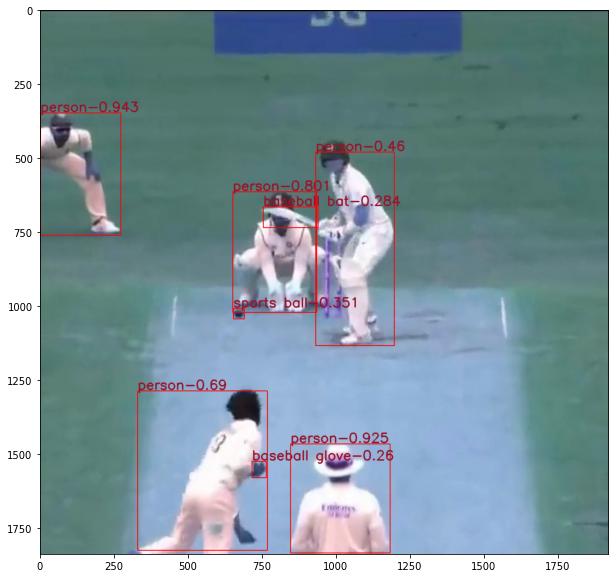

(1836, 1920, 3)
1836 1920


In [56]:
plt_img(imc)
# obj
print(imc.shape)
mp = 3
print(im0s.shape[0] * mp, im0s.shape[1] * mp)

In [48]:
obj_list

[[0, [0.0, 320.0, 356.0, 368.0], 0.9506310820579529],
 [0, [863.0, 1311.0, 292.0, 517.0], 0.9395336508750916],
 [0, [689.0, 562.0, 240.0, 358.0], 0.9051260948181152],
 [0, [795.0, 375.0, 376.0, 601.0], 0.49648091197013855],
 [0, [550.0, 1091.0, 299.0, 594.0], 0.2734898030757904]]

##### Pred check

In [ ]:
yl_lbl = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
print(yl_lbl.index('tennis racket'))
print(yl_lbl.index('baseball bat'))

38
34


### Instance Identification

#### Prediction Check

In [ ]:
# pitch_obj = dt_obj.copy(deep=True)
pitch_obj.reset_index(drop=True, inplace=True)
pitch_obj.rename(columns={'fname': 'Image', 'bbox': 'pt_bbox'}, inplace=True)
pitch_obj

,Image,vid,frame,label,conf,pt_bbox
0,ICC_WC_2019_v1_169_171_sh_21__27,ICC_WC_2019_v1_169_171_sh_21,27,0,0.603147,"[71.0, 199.0, 447.0, 409.0]"


In [ ]:
# pitch_obj = dt_obj.copy(deep=True)
ball_obj.reset_index(drop=True, inplace=True)
ball_obj.rename(columns={'fname': 'Image', 'bbox': 'ball_bbox'}, inplace=True)
ball_obj

,Image,vid,frame,label,conf,ball_bbox
0,ICC_WC_2019_v1_169_171_sh_21__27,ICC_WC_2019_v1_169_171_sh_21,27,0,0.909518,"[229.0, 283.0, 16.0, 18.0]"


In [ ]:
df_pr.columns

Index(['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class', 'name', 'Image',
       'Bounding Box', 'cls_nm', 'bbox', 'ctd'],
      dtype='object')

In [ ]:
idf_pr = df_pr[df_pr['Image']==fnm]
idf_pr = idf_pr.merge(pitch_obj[['Image', 'pt_bbox']], on='Image', how='left')
idf_pr = idf_pr.merge(ball_obj[['Image', 'ball_bbox']], on='Image', how='left')
idf_pr[['name', 'Image', 'Bounding Box', 'cls_nm', 'bbox', 'ctd']]

,name,Image,Bounding Box,cls_nm,bbox,ctd
0,person_1,ICC_WC_2019_v1_169_171_sh_21__27,"[165.17819213867188, 393.24517822265625, 260.8...",person,"(165.17819213867188, 393.24517822265625, 260.8...","[213, 485]"
1,person_2,ICC_WC_2019_v1_169_171_sh_21__27,"[249.153564453125, 442.4283447265625, 333.3925...",person,"(249.153564453125, 442.4283447265625, 333.3925...","[291, 526]"
2,person_3,ICC_WC_2019_v1_169_171_sh_21__27,"[389.6861267089844, 332.1554870605469, 505.816...",person,"(389.6861267089844, 332.1554870605469, 505.816...","[447, 448]"
3,person_4,ICC_WC_2019_v1_169_171_sh_21__27,"[258.42230224609375, 90.03663635253906, 325.83...",person,"(258.4223022460937, 90.03663635253906, 325.836...","[292, 179]"
4,person_5,ICC_WC_2019_v1_169_171_sh_21__27,"[381.8777770996094, 0.5744829177856445, 447.93...",person,"(381.8777770996094, 0.5744829177856445, 447.93...","[414, 14]"
5,person_6,ICC_WC_2019_v1_169_171_sh_21__27,"[379.7215576171875, 0.5216798782348633, 404.68...",person,"(379.7215576171875, 0.5216798782348633, 404.68...","[392, 13]"


In [ ]:
fr_wd = 640#612
fr_ht = 612#640
# idf_pr = df_pr[df_pr['Image']==fnm]
# idf_pr = idf_pr.merge(pitch_obj[['Image', 'pt_bbox']], on='Image',)
idf_pr['pt_ctd'] = idf_pr['pt_bbox'].apply(lambda x: [int((x[0]+x[2]/2)), int((x[1]+x[3]/2))])
idf_pr['ball_ctd'] = idf_pr['ball_bbox'].apply(lambda x: [int((x[0]+x[2]/2)), int((x[1]+x[3]/2))])
idf_pr.columns

Index(['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class', 'name', 'Image',
       'Bounding Box', 'cls_nm', 'bbox', 'ctd', 'pt_bbox', 'ball_bbox',
       'pt_ctd', 'ball_ctd'],
      dtype='object')

In [ ]:
idf_pr['ctd_x'] = idf_pr['bbox'].apply(lambda x: int((x[0]+x[2])/2))
idf_pr['ctd_y'] = idf_pr['bbox'].apply(lambda x: int((x[1]+x[3])/2))
idf_pr['pt_ctd_x'] = idf_pr['pt_ctd'].apply(lambda x: x[0])
idf_pr['ball_ctd_x'] = idf_pr['ball_ctd'].apply(lambda x: x[0])
idf_pr.sort_values(['cls_nm', 'ctd_y'], ascending=True, inplace=True)
idf_pr['pos_img'] = np.where(idf_pr['ctd_y'] <= fr_ht/2, 'up', 'low')
idf_pr.sort_values(['cls_nm', 'pos_img', 'ctd_x'], ascending=True, inplace=True)
idf_pr[['name', 'Image', 'cls_nm', 'bbox', 'ctd', 'pt_bbox', 'pt_ctd', 'ctd_x', 'ctd_y', 'pt_ctd_x', 'pos_img']]

,name,Image,cls_nm,bbox,ctd,...,pt_ctd,ctd_x,ctd_y,pt_ctd_x,pos_img
0,person_1,ICC_WC_2019_v1_169_171_sh_21__27,person,"(165.17819213867188, 393.24517822265625, 260.8...","[213, 485]",...,"[294, 403]",213,485,294,low
1,person_2,ICC_WC_2019_v1_169_171_sh_21__27,person,"(249.153564453125, 442.4283447265625, 333.3925...","[291, 526]",...,"[294, 403]",291,526,294,low
2,person_3,ICC_WC_2019_v1_169_171_sh_21__27,person,"(389.6861267089844, 332.1554870605469, 505.816...","[447, 448]",...,"[294, 403]",447,448,294,low
3,person_4,ICC_WC_2019_v1_169_171_sh_21__27,person,"(258.4223022460937, 90.03663635253906, 325.836...","[292, 179]",...,"[294, 403]",292,179,294,up
5,person_6,ICC_WC_2019_v1_169_171_sh_21__27,person,"(379.7215576171875, 0.5216798782348633, 404.68...","[392, 13]",...,"[294, 403]",392,13,294,up
4,person_5,ICC_WC_2019_v1_169_171_sh_21__27,person,"(381.8777770996094, 0.5744829177856445, 447.93...","[414, 14]",...,"[294, 403]",414,14,294,up


In [ ]:
idf_pr['near_pt'] = np.where(abs(idf_pr['ctd_x']-idf_pr['pt_ctd_x'])<=10, 'pt_ct', 'away')
# idf_pr['ball_pos'] = np.where(idf_pr['ball_ctd_x'] <= fr_wd/2, 'left', 'right')
idf_pr['ball_pos'] = ''
idf_pr['ball_pos'] = np.where(((idf_pr['ball_ctd_x'] <= fr_wd/2) & (idf_pr['ctd_x'] <= fr_wd/2)), 'ball_side', idf_pr['ball_pos'])
idf_pr['ball_pos'] = np.where(((idf_pr['ball_ctd_x'] >= fr_wd/2) & (idf_pr['ctd_x'] >= fr_wd/2)), 'ball_side', idf_pr['ball_pos'])
idf_pr['ball_pos'] = np.where(idf_pr['ball_pos']=='', 'other_side', idf_pr['ball_pos'])
idf_pr['ins_cls'] = ''
idf_pr['ins_cls'] = np.where(((idf_pr['pos_img']=='low') & (idf_pr['near_pt']=='pt_ct')), 'Umpire', idf_pr['ins_cls'])
idf_pr['ins_cls'] = np.where(((idf_pr['pos_img']=='up') & (idf_pr['near_pt']=='pt_ct')), 'Striker', idf_pr['ins_cls'])
idf_pr['ins_cls'] = np.where(((idf_pr['pos_img']=='low') & (idf_pr['near_pt']=='away') & (idf_pr['ball_pos']=='ball_side')), 'Bowler', idf_pr['ins_cls'])
idf_pr['ins_cls'] = np.where(((idf_pr['pos_img']=='low') & (idf_pr['near_pt']=='away') & (idf_pr['ball_pos']=='other_side')), 'Non_Striker', idf_pr['ins_cls'])
idf_pr[['name', 'pt_ctd', 'ctd_x', 'ctd_y', 'pt_ctd_x', 'ball_ctd_x', 'pos_img', 'near_pt', 'ball_pos', 'ins_cls']]

,name,pt_ctd,ctd_x,ctd_y,pt_ctd_x,ball_ctd_x,pos_img,near_pt,ball_pos,ins_cls
0,person_1,"[294, 403]",213,485,294,237,low,away,ball_side,Bowler
1,person_2,"[294, 403]",291,526,294,237,low,pt_ct,ball_side,Umpire
2,person_3,"[294, 403]",447,448,294,237,low,away,other_side,Non_Striker
3,person_4,"[294, 403]",292,179,294,237,up,pt_ct,ball_side,Striker
5,person_6,"[294, 403]",392,13,294,237,up,away,other_side,
4,person_5,"[294, 403]",414,14,294,237,up,away,other_side,


In [ ]:
print(idf_pr.columns)
idf_pr['bbox'][0]

Index(['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class', 'name', 'Image',
       'Bounding Box', 'cls_nm', 'bbox', 'ctd', 'pt_bbox', 'ball_bbox',
       'pt_ctd', 'ball_ctd', 'ctd_x', 'ctd_y', 'pt_ctd_x', 'pos_img',
       'near_pt', 'ball_ctd_x', 'ball_pos', 'ins_cls'],
      dtype='object')


(165.17819213867188, 393.24517822265625, 260.8395080566406, 578.6295776367188)

In [ ]:
tzip = list(zip(idf_pr['name'], idf_pr['bbox'], idf_pr['pt_bbox'], idf_pr['ctd'], idf_pr['ball_ctd'], idf_pr['ins_cls']))
tzip

[('person_1',
  (165.17819213867188,
   393.24517822265625,
   260.8395080566406,
   578.6295776367188),
  [71.0, 199.0, 447.0, 409.0],
  [213, 485],
  [237, 292],
  'Bowler'),
 ('person_2',
  (249.153564453125, 442.4283447265625, 333.3925170898437, 610.53125),
  [71.0, 199.0, 447.0, 409.0],
  [291, 526],
  [237, 292],
  'Umpire'),
 ('person_3',
  (389.6861267089844, 332.1554870605469, 505.8166809082031, 565.427001953125),
  [71.0, 199.0, 447.0, 409.0],
  [447, 448],
  [237, 292],
  'Non_Striker'),
 ('person_4',
  (258.4223022460937, 90.03663635253906, 325.8369140625, 268.411376953125),
  [71.0, 199.0, 447.0, 409.0],
  [292, 179],
  [237, 292],
  'Striker'),
 ('person_6',
  (379.7215576171875,
   0.5216798782348633,
   404.6897583007813,
   25.99108123779297),
  [71.0, 199.0, 447.0, 409.0],
  [392, 13],
  [237, 292],
  ''),
 ('person_5',
  (381.8777770996094,
   0.5744829177856445,
   447.9340515136719,
   27.553939819335938),
  [71.0, 199.0, 447.0, 409.0],
  [414, 14],
  [237, 292],
 

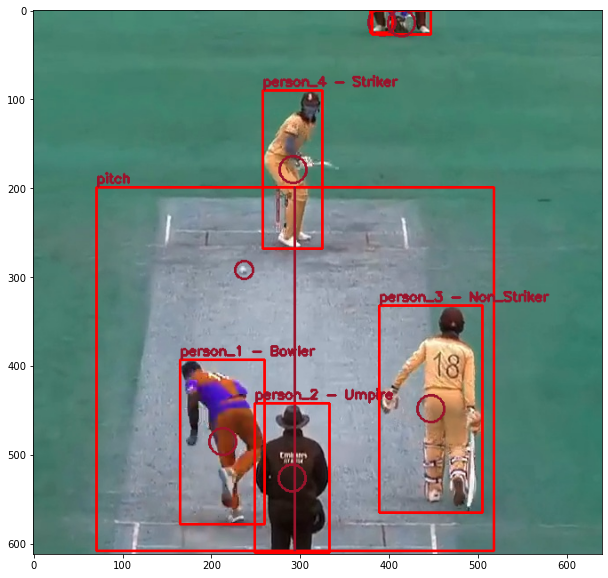

In [ ]:
im4 = im0.copy()
for ni, blt in enumerate(tzip):
    if ni==0:
        ### Pitch Bbox
        pbbox = blt[2]
        p1 = (int(pbbox[0]), int(pbbox[1]))
        p2 = (int(pbbox[0] + pbbox[2]), int(pbbox[1] + pbbox[3]))
        cv2.rectangle(im4, p1, p2, (255,0,0), 2, 1)
        (x, y) = p1
        # draw a bounding box rectangle and label on the image
        # b=9
        # color = [int(c) for c in COLORS[b]]
        # color = [255, 255, 255]
        color = [153, 20, 44]
        text = f'pitch'
        cv2.putText(im4, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        ### Pitch Centre line
        p1 = (int(pbbox[0] + pbbox[2]/2), int(pbbox[1]))
        p2 = (int(pbbox[0] + pbbox[2]/2), int(pbbox[1] + pbbox[3]))
        # print(p1, p2)
        cv2.line(im4, p1, p2, color, 2)
        # ball circle
        cv2.circle(im4, blt[4], 10, color, 2)
        
    ### Person Bbox
    tbbox = blt[1]
    p1 = (int(tbbox[0]), int(tbbox[1]))
    p2 = (int(tbbox[2]), int(tbbox[3]))
    cv2.rectangle(im4, p1, p2, (255,0,0), 2, 1)
    (x, y) = p1
    # draw a bounding box rectangle and label on the image
    # b=9
    # color = [int(c) for c in COLORS[b]]
    # color = [255, 255, 255]
    color = [153, 20, 44]
    text = f'{blt[0]} - {blt[5]}'
    cv2.putText(im4, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    # Centroid circle
    cv2.circle(im4, blt[3], 15, color, 2)
plt_img(im4)

In [ ]:
sm_im_dt = sh1[(sh1['Image']==fnm) & (sh1['cls_nm']=='person')].reset_index()
sm_im_dt['ctd_x'] = sm_im_dt['bbox'].apply(lambda x: int((x[0]+x[2])/2))
sm_im_dt['ctd_y'] = sm_im_dt['bbox'].apply(lambda x: int((x[1]+x[3])/2))
sm_im_dt.sort_values(['cls_nm', 'ctd_y'], ascending=True, inplace=True)
sm_im_dt['pos_img'] = np.where(sm_im_dt['ctd_y'] <= 612/2, 'up', 'low')
sm_im_dt.sort_values(['cls_nm', 'pos_img', 'ctd_x'], ascending=True, inplace=True)
sm_im_dt['near_center'] = np.where(abs(sm_im_dt['ctd_x']-(640/2))<=25, 'near_cent', 'far')
sm_im_dt[['name', 'ctd_y', 'pos_img', 'ctd_x', 'near_center']]

plt_img(im1)

val = pr_bbox['person_1']
ctd = [int((bbox[0]+bbox[2])/2), int((bbox[1]+bbox[3])/2)]

val = list(val)
obj_txt = seg_ins(val[:4])
# print(f'{key} - {val[:4]} ======> {seg_ins(val[:4])}')

bbox = list(val[:4])
p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[2]), int(bbox[3])) # (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(im1, p1, p2, (255,0,0), 2, 1)
#plt_img(im1)
(x, y) = p1
# draw a bounding box rectangle and label on the image
# b=9
# color = [int(c) for c in COLORS[b]]
color = [153, 20, 44]
cv2.putText(im1, obj_txt, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
